In [1]:
%matplotlib inline 

import six
import Quandl
import calendar
import numpy as np
import pandas as pd
import pylab as pylab
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
import statsmodels.tsa.stattools as stats
from helpers import correlation, procces_stocks, data_manipulation, download_quandl_data


import sys
from os import listdir
from os.path import isfile, join

In [2]:
GOLD = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/GOLD_new.csv')
SILVER = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/SILVER_new.csv')
PLAT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/PLAT_new.csv')
INDEX_DJIA = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA_new.csv')
INDEX_HSI = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_HSI_new.csv')
INDEX_IBEX = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX_new.csv')
INDEX_N225 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_N225_new.csv')
INDEX_SP500 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_SP500_new.csv')
values_names = ['GOLD', 'SILVER', 'PLAT', 'INDEX_DJIA', 'INDEX_HSI', 'INDEX_IBEX', 'INDEX_N225', 'INDEX_SP500']
values = [GOLD['USD (AM)'], SILVER['USD'], PLAT['USD AM'], INDEX_DJIA['Close'], INDEX_HSI['Close'], INDEX_IBEX['Close'], INDEX_N225['Close'], INDEX_SP500['Close']]

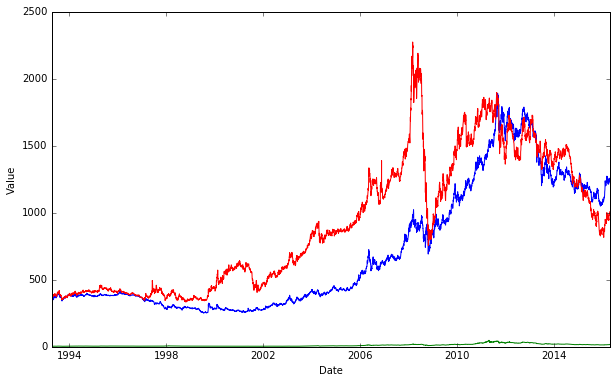

In [81]:
fig_size = [10, 6]
plt.rcParams["figure.figsize"] = fig_size
plt.xlabel('Date')
plt.ylabel('Value')

x = [datetime.strptime(d,'%Y-%m-%d').date() for d in GOLD['Date'].tolist()]

plt.plot(x, GOLD['USD (AM)'], 'b')
plt.plot(x, SILVER['USD'], 'g')
plt.plot(x, PLAT['USD AM'], 'r')
plt.show()

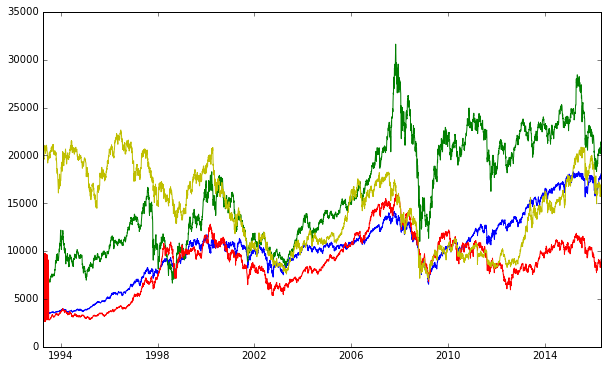

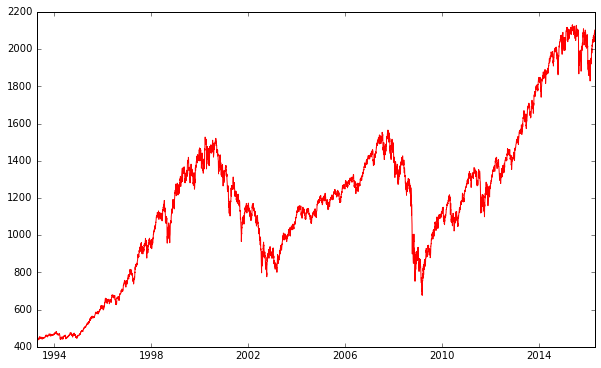

In [6]:
plt.rcParams["figure.figsize"] = fig_size
pylab.figure(0)
x = [datetime.strptime(d,'%Y-%m-%d').date() for d in INDEX_DJIA['Date'].tolist()]

plt.plot(x, INDEX_DJIA['Close'], 'b')
plt.plot(x, INDEX_HSI['Close'], 'g')
plt.plot(x, INDEX_IBEX['Close'], 'r')
plt.plot(x, INDEX_N225['Close'], 'y')
pylab.figure(1)
plt.plot(x, INDEX_SP500['Close'], 'r')
plt.show()

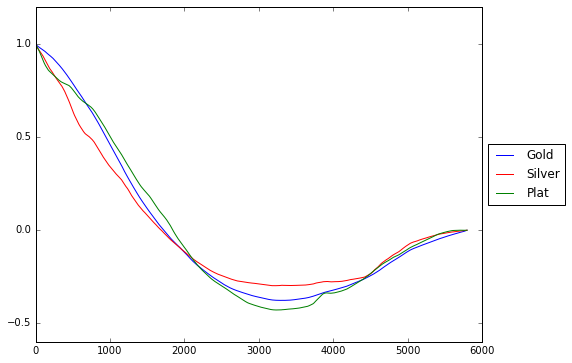

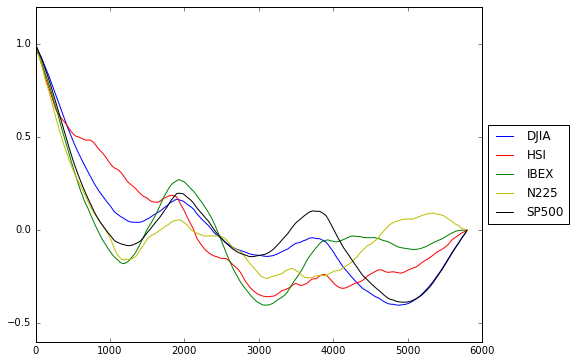

In [87]:
#####################
#  AUTOCORRELATION  #
#####################

x = [datetime.strptime(d,'%Y-%m-%d').date() for d in INDEX_DJIA['Date'].tolist()]
nlag = len(x)

acf_gold = correlation.autocorrelationf(GOLD['USD (AM)'], nlag, True)
acf_silver = correlation.autocorrelationf(SILVER['USD'], nlag, True)
acf_plat = correlation.autocorrelationf(PLAT['USD AM'], nlag, True)

acf_djia = correlation.autocorrelationf(INDEX_DJIA['Close'], nlag, True)
acf_hsi = correlation.autocorrelationf(INDEX_HSI['Close'], nlag, True)
acf_ibex = correlation.autocorrelationf(INDEX_IBEX['Close'], nlag, True)
acf_n225 = correlation.autocorrelationf(INDEX_N225['Close'], nlag, True)
acf_sp500 = correlation.autocorrelationf(INDEX_SP500['Close'], nlag, True)
                
ccf = correlation.crosscorrelation(GOLD['USD (AM)'], GOLD['USD (AM)'], False)
plt.rcParams["figure.figsize"] = fig_size
pylab.figure(0)

ax = plt.subplot(111)
ax.plot(acf_gold, 'b', label='Gold')
ax.plot(acf_silver, 'r', label='Silver')
ax.plot(acf_plat, 'g', label='Plat')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

pylab.figure(1)

ax = plt.subplot(111)
ax.plot(acf_djia, 'b', label='DJIA')
ax.plot(acf_hsi, 'r', label='HSI')
ax.plot(acf_ibex, 'g', label='IBEX')
ax.plot(acf_n225, 'y', label='N225')
ax.plot(acf_sp500, 'k', label='SP500')
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


Cross correlation between GOLD and SILVER, color indigo
Cross correlation between GOLD and PLAT, color hotpink
Cross correlation between GOLD and INDEX_DJIA, color indianred
Cross correlation between GOLD and INDEX_HSI, color yellow
Cross correlation between GOLD and INDEX_IBEX, color darkolivegreen
Cross correlation between GOLD and INDEX_N225, color darkseagreen
Cross correlation between GOLD and INDEX_SP500, color tomato


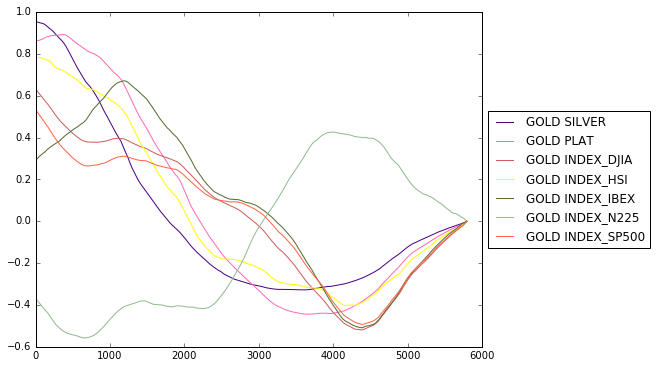

In [90]:
######################
#  CROSSCORRELATION  #
######################

colors_ = list(six.iteritems(colors.cnames))
x = [datetime.strptime(d,'%Y-%m-%d').date() for d in INDEX_DJIA['Date'].tolist()]
pylab.figure(0)
ax = plt.subplot(111)

cross_correlations = []
plots = []
color_iter = iter(colors_)
for i in range(1):
    for j in range(len(values)):
        if i != j:            
            temp = correlation.crosscorrelation(values[i], values[j], True)
            legend = str(values_names[i]) + ' ' + str(values_names[j])
            cross_correlations.append(temp)  
            color = next(color_iter)[0]
            plots.append(ax.plot( temp, color, label=legend))
            next(color_iter)
            print("Cross correlation between %s and %s, color %s" % (values_names[i], values_names[j], color))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [64]:
def difference_between_consecutive_days(df, colname):
    """
    Calculates the difference between n day and n+1 day
    If price is higher it set the n+1 column value to 1, otherwise to 0  
    
    It return the number of days that the value increases and the number of days the value decreases
    """

    df['Diff'] = df[colname] - df[colname].shift(1)
    df['Diff2'] = df['Diff'].apply(lambda x: 1 if x > 0 else 0)
    
    ones = GOLD.loc[:,('Diff2')][GOLD.loc[:,('Diff2')] == 1].values.shape[0]
    zeros = GOLD.loc[:,('Diff2')][GOLD.loc[:,('Diff2')] == 0].values.shape[0]    
    return zeros, ones

def consecutive_days_tendency(df, colname):
    """
    """
    max_zeros = temp_zeros = 0
    max_ones = temp_ones = 0
    
    for i in range(df.shape[0]):
        if df[colname][i] == 0:
            temp_zeros = temp_zeros + 1  
            if temp_ones > max_ones:
                max_ones = temp_ones
                date_ones = df['Date'][i-max_ones]
            temp_ones = 0
        else:
            temp_ones = temp_ones + 1    
            if temp_zeros > max_zeros:
                max_zeros = temp_zeros
                date_zeros = df['Date'][i-max_zeros]
            temp_zeros = 0

    return max_zeros, max_ones, date_zeros, date_ones

In [79]:
## PRICE FLOW BETWEEN TWO CONSECUTIVES DAYS ##

difference_between_consecutive_days(GOLD, 'USD (AM)')
difference_between_consecutive_days(PLAT, 'USD AM')
zeros, ones, date_zeros, date_ones = consecutive_days_tendency(GOLD, 'Diff2')



In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(100)
rfc.fit(trainX, trainY)
rfc.predict(testX)